<div>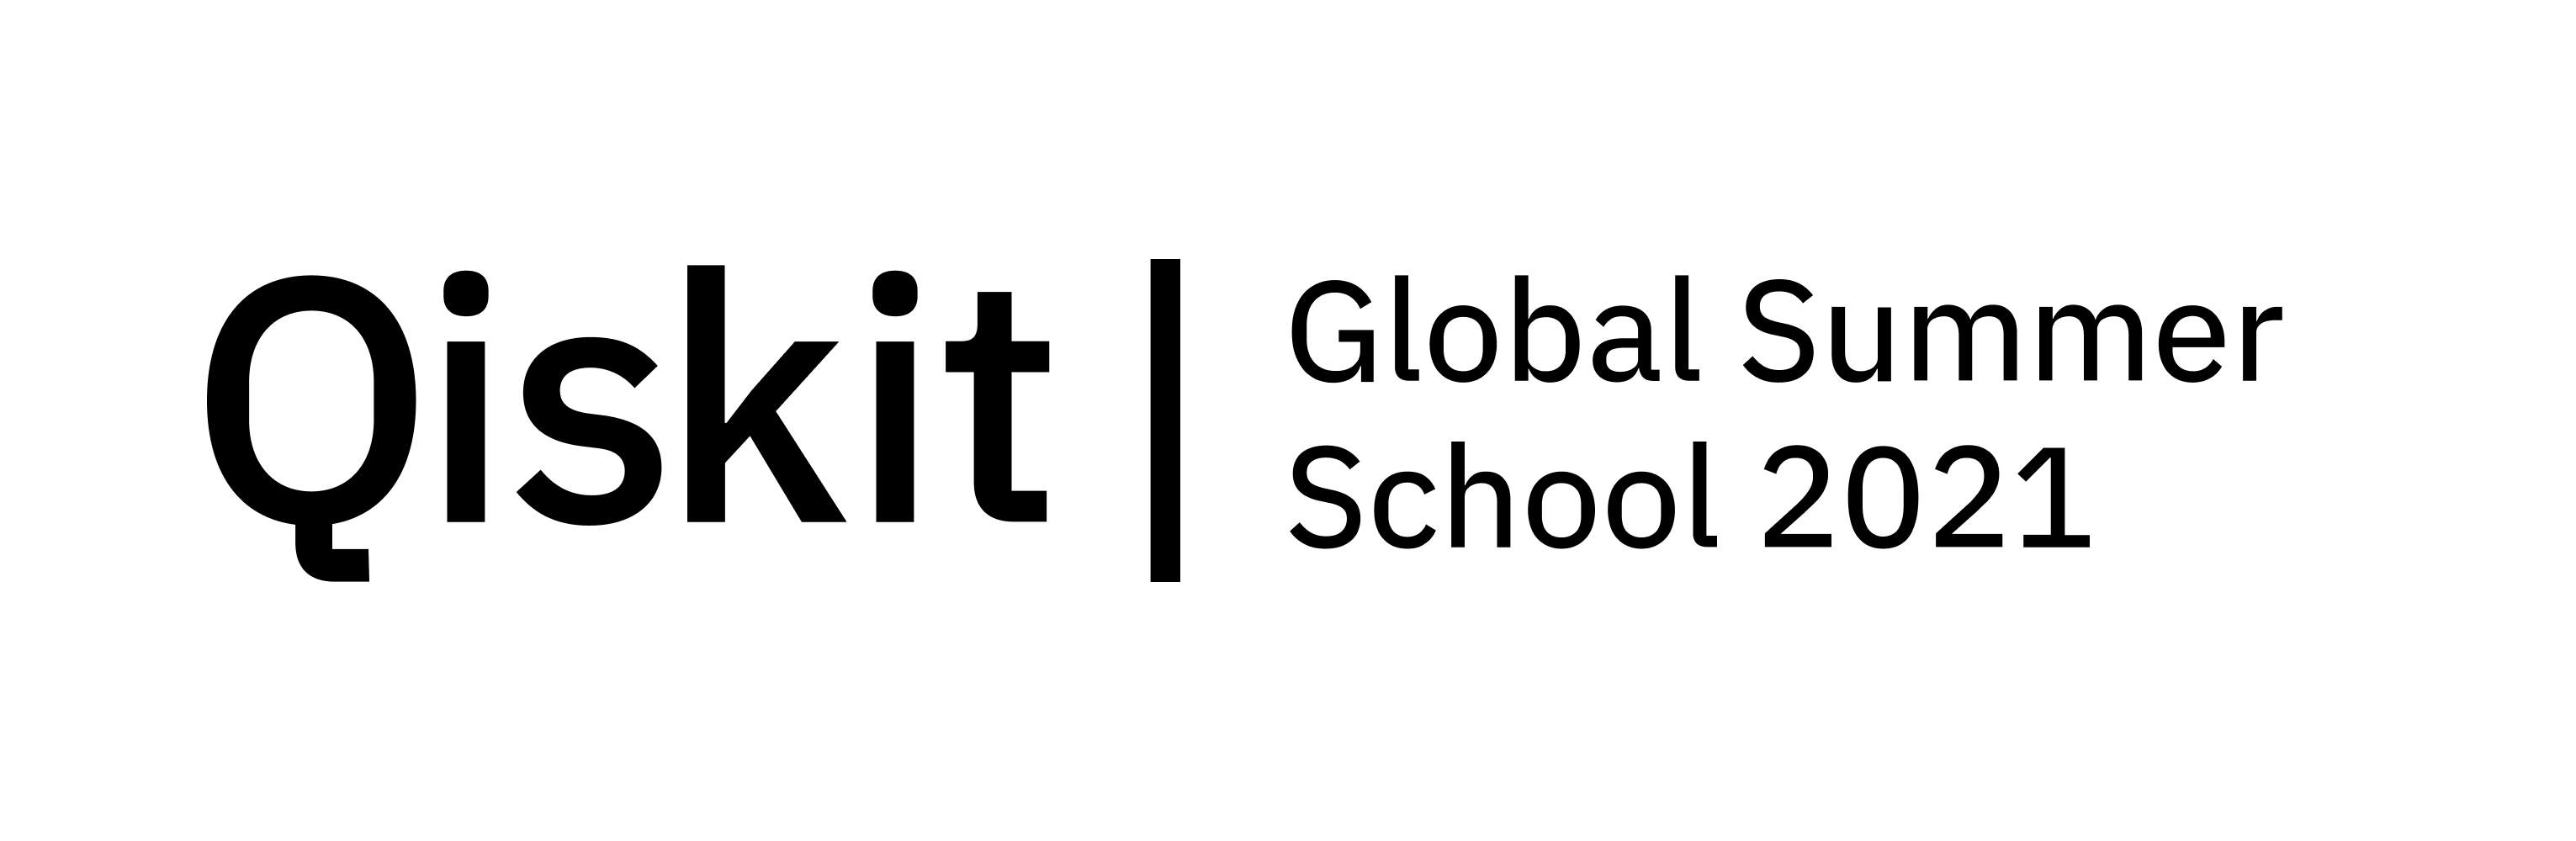</div>

# Lab 3: Quantum Kernels and Support Vector Machines

In this lab, you will learn how to implement quantum feature maps, quantum kernels and quantum support vector classification in Qiskit. 

We will first load the required packages.

In [1]:
# General Imports
import numpy as np

# Visualisation Imports
import matplotlib.pyplot as plt

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

# Data

The data we are going to work with today will be a small subset of the well known handwritten [digits dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#digits-dataset), which is available through scikit-learn. We will be aiming to differentiate between '0' and '1'. 

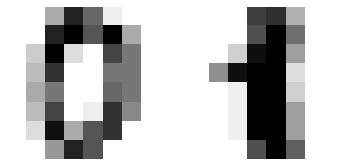

In [2]:
# Load digits dataset
digits = datasets.load_digits(n_class=2)

# Plot example '0' and '1'
fig, axs = plt.subplots(1, 2, figsize=(6,3))
axs[0].set_axis_off()
axs[0].imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')
axs[1].set_axis_off()
axs[1].imshow(digits.images[1], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

## Data Preprocessing

There are a total of 360 datapoints in the dataset. Each datapoint is a 8x8 image of a digit, collapsed into an array, where each element is an integer between 0 (white) and 16 (black). As per classical classification, we need to split the dataset into training (100) and testing (20) samples, and normalise it. To use the dataset for quantum classification, we need to scale the range to between -1 and 1, and reduce the dimensionality to the number of qubits we want to use (4).

Note that in Qiskit, this is done for this dataset in [`qiskit_machine_learning.datasets.digits`](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.datasets.digits.html), but it is made explicit in this lab for future reference. 

In [3]:
# Split dataset
sample_train, sample_test, label_train, label_test = train_test_split(
     digits.data, digits.target, test_size=0.2, random_state=22)

# Reduce dimensions
n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Select
train_size = 100
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 20
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [4]:
print(sample_train[0], label_train[0])
print(sample_test[0], label_test[0])

[-0.79923362 -0.26571862 -0.16474421 -0.17815209] 0
[ 0.41948352 -0.83602799  0.72200828 -0.373356  ] 1


## Data Encoding

We will take the classical data and encode it to the quantum state space using a quantum feature map. The choice of which feature map to use is important and may depend on the given dataset we want to classify. Here we'll look at the feature maps available in Qiskit, before selecting and customising one to encode our data.

### Quantum Feature Maps

As the name suggests, a quantum feature map $\phi(\mathbf{x})$ is a map from the classical feature vector $\mathbf{x}$ to the quantum state $|\Phi(\mathbf{x})\rangle\langle\Phi(\mathbf{x})|$. This is faciliated by applying the unitary operation $\mathcal{U}_{\Phi(\mathbf{x})}$ on the initial state $|0\rangle^{n}$ where _n_ is the number of qubits being used for encoding.

The feature maps currently available in Qiskit ([`PauliFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliFeatureMap.html), [`ZZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZFeatureMap.html) and [`ZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html)) are those introduced in [_Havlicek et al_.  Nature **567**, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2), in particular the `ZZFeatureMap` is conjectured to be hard to simulate classically and can be implemented as short-depth circuits on near-term quantum devices.

The `PauliFeatureMap` is defined as:

```python
PauliFeatureMap(feature_dimension=None, reps=2, 
                entanglement='full', paulis=None, 
                data_map_func=None, parameter_prefix='x',
                insert_barriers=False)
```

and describes the unitary operator of depth $d$:

$$ \mathcal{U}_{\Phi(\mathbf{x})}=\prod_d U_{\Phi(\mathbf{x})}H^{\otimes n},\ U_{\Phi(\mathbf{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\mathbf{x})\prod_{k\in S} P_i\right), $$

which contains layers of Hadamard gates interleaved with entangling blocks, $U_{\Phi(\mathbf{x})}$, encoding the classical data as shown in circuit diagram below for $d=2$.

<div>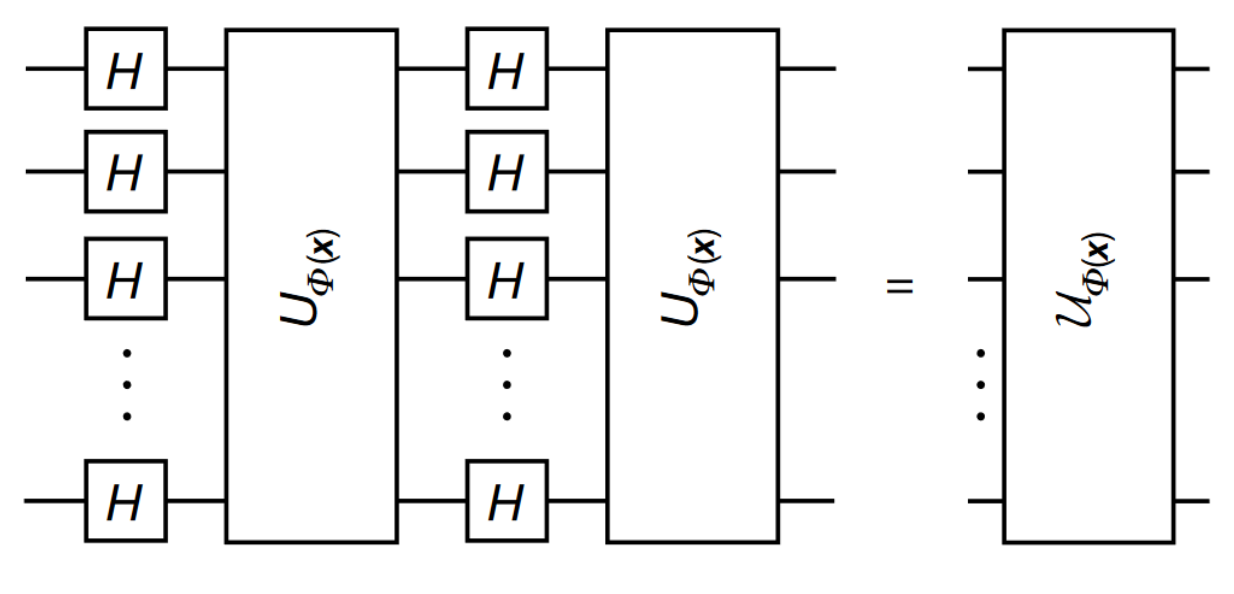</div>

Within the entangling blocks, $U_{\Phi(\mathbf{x})}$: $P_i \in \{ I, X, Y, Z \}$ denotes the Pauli matrices, the index $S$ describes connectivities between different qubits or datapoints: $S \in \{\binom{n}{k}\ combinations,\ k = 1,... n \}$, and by default the data mapping function $\phi_S(\mathbf{x})$ is 
$$\phi_S:\mathbf{x}\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$$

when $k = 1, P_0 = Z$, this is the `ZFeatureMap`: 
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$

which is defined as:
```python
ZFeatureMap(feature_dimension, reps=2, 
            data_map_func=None, insert_barriers=False)
```

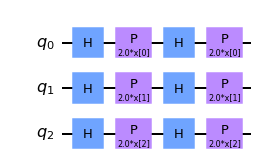

In [5]:
# 3 features, depth 2
map_z = ZFeatureMap(feature_dimension=3, reps=2)
map_z.decompose().draw('mpl')

note the lack of entanglement in this feature map, this means that this feature map is simple to simulate classically and will not provide quantum advantage.

and when $k = 2, P_0 = Z, P_1 = ZZ$, this is the `ZZFeatureMap`: 
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$ 

which is defined as:
```python
ZZFeatureMap(feature_dimension, reps=2, 
             entanglement='full', data_map_func=None, 
             insert_barriers=False)
```

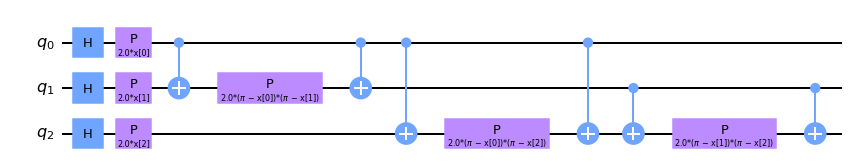

In [6]:
# 3 features, depth 1
map_zz = ZZFeatureMap(feature_dimension=3, reps=1)
map_zz.decompose().draw('mpl')

now that there is entanglement in the feature map, we can define the entanglement map:

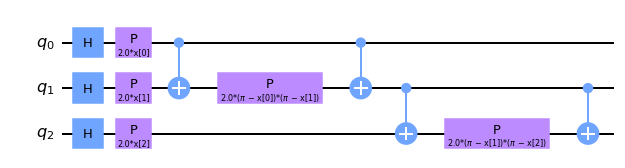

In [7]:
# 3 features, depth 1, linear entanglement
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='linear')
map_zz.decompose().draw('mpl')

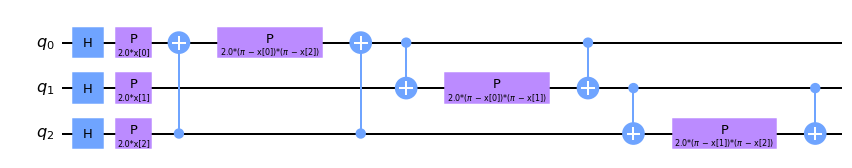

In [8]:
# 3 features, depth 1, circular entanglement
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='circular')
map_zz.decompose().draw('mpl')

We can also customise the Pauli gates in the feature map, for example, $P_0 = X, P_1 = Y, P_2 = ZZ$:
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_{j} \phi_{\{j\}}(\mathbf{x}) \, Y_j\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, X_j\right) \, H^{\otimes n} \right)^d.$$ 

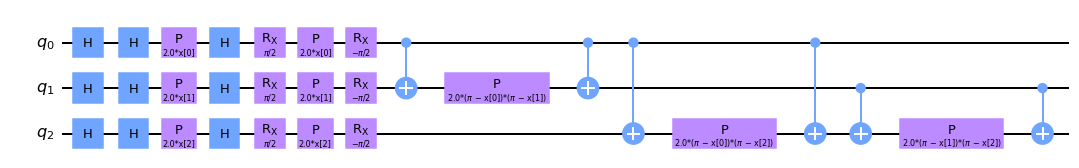

In [9]:
# 3 features, depth 1
map_pauli = PauliFeatureMap(feature_dimension=3, reps=1, paulis = ['X', 'Y', 'ZZ'])
map_pauli.decompose().draw('mpl')

We can also define a custom data mapping function, for example: 
$$\phi_S:\mathbf{x}\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        \sin(\pi-x_i)\sin(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$$

In [10]:
def custom_data_map_func(x):
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: m * n, np.sin(np.pi - x))
    return coeff

In [11]:
map_customdatamap = PauliFeatureMap(feature_dimension=3, reps=1, paulis=['Z','ZZ'],
                                    data_map_func=custom_data_map_func)

#map_customdatamap.draw() # qiskit isn't able to draw the circuit with np.sin in the custom data map 

The [`NLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.NLocal.html) and [`TwoLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html) functions in Qiskit's circuit library can also be used to create parameterized quantum circuits as feature maps. 

```python
TwoLocal(num_qubits=None, reps=3, rotation_blocks=None, 
         entanglement_blocks=None, entanglement='full',  
         skip_unentangled_qubits=False, 
         skip_final_rotation_layer=False, 
         parameter_prefix='θ', insert_barriers=False, 
         initial_state=None)
```

```python
NLocal(num_qubits=None, reps=1, rotation_blocks=None, 
       entanglement_blocks=None, entanglement=None,   
       skip_unentangled_qubits=False, 
       skip_final_rotation_layer=False, 
       overwrite_block_parameters=True, 
       parameter_prefix='θ', insert_barriers=False, 
       initial_state=None, name='nlocal')
```

Both functions create parameterized circuits of alternating rotation and entanglement layers. In both layers, parameterized circuit-blocks act on the circuit in a defined way. In the rotation layer, the blocks are applied stacked on top of each other, while in the entanglement layer according to the entanglement strategy. Each layer is repeated a number of times, and by default a final rotation layer is appended.

In `NLocal`, the circuit blocks can have arbitrary sizes (smaller equal to the number of qubits in the circuit), while in `TwoLocal`, the rotation layers are single qubit gates applied on all qubits and the entanglement layer uses two-qubit gates.

For example, here is a `TwoLocal` circuit, with $R_y$ and $R_Z$ gates in the rotation layer and $CX$ gates in the entangling layer with circular entanglement:

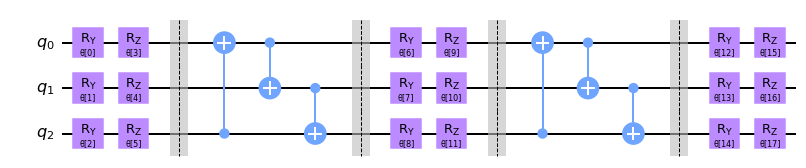

In [12]:
twolocal = TwoLocal(num_qubits=3, reps=2, rotation_blocks=['ry','rz'], 
               entanglement_blocks='cx', entanglement='circular', insert_barriers=True)
twolocal.decompose().draw('mpl')

and the equivalent `NLocal` circuit:

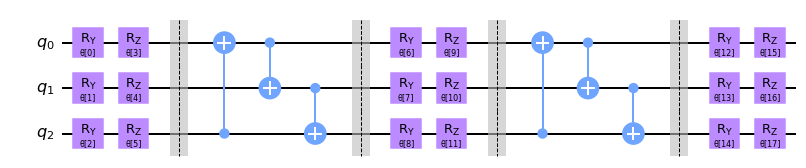

In [13]:
twolocaln = NLocal(num_qubits=3, reps=2,
               rotation_blocks=[RYGate(Parameter('a')), RZGate(Parameter('a'))], 
               entanglement_blocks=CXGate(), 
               entanglement='circular', insert_barriers=True)
twolocaln.decompose().draw('mpl')

Here is another `NLocal` circuit, with a rotation block on 2 qubits and an entanglement block on 4 qubits using linear entanglement:

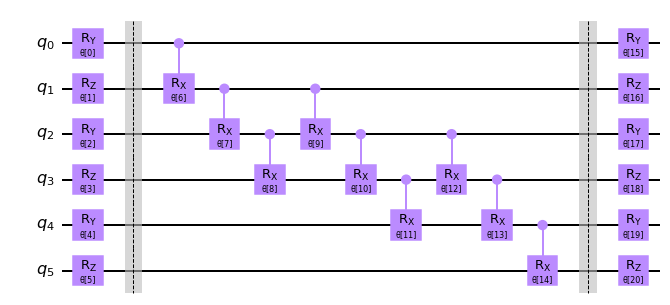

In [14]:
# rotation block:
rot = QuantumCircuit(2)
params = ParameterVector('r', 2)
rot.ry(params[0], 0)
rot.rz(params[1], 1)

# entanglement block:
ent = QuantumCircuit(4) 
params = ParameterVector('e', 3)
ent.crx(params[0], 0, 1)
ent.crx(params[1], 1, 2)
ent.crx(params[2], 2, 3)

nlocal = NLocal(num_qubits=6, rotation_blocks=rot, entanglement_blocks=ent, 
                entanglement='linear', insert_barriers=True)
nlocal.decompose().draw('mpl')

It is also possible to create a completely custom parameterized circuit feature map. To do so, simply create a `QuantumCircuit` with a [`ParameterVector`](https://qiskit.org/documentation/stubs/qiskit.circuit.ParameterVector.html). Here's an example:

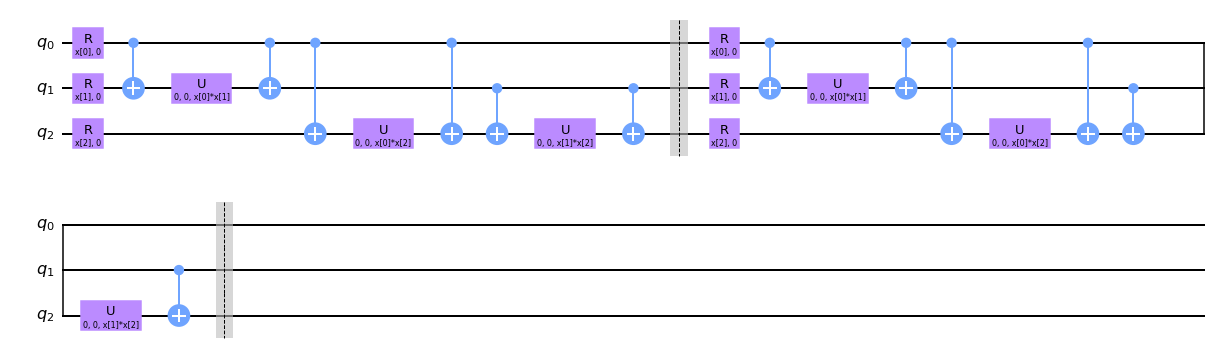

In [15]:
qubits = 3     
repeats = 2

x = ParameterVector('x', length=qubits)
var_custom = QuantumCircuit(qubits)

for _ in range(repeats):
    for i in range(qubits):
        var_custom.rx(x[i], i)
    for i in range(qubits):
        for j in range(i + 1, qubits):
            var_custom.cx(i, j)
            var_custom.p(x[i] * x[j], j)
            var_custom.cx(i, j)
    var_custom.barrier()
            
var_custom.decompose().draw('mpl')

Let's encode the first training sample using the `ZZFeatureMap`:

In [16]:
print(sample_train[0])

[-0.79923362 -0.26571862 -0.16474421 -0.17815209]


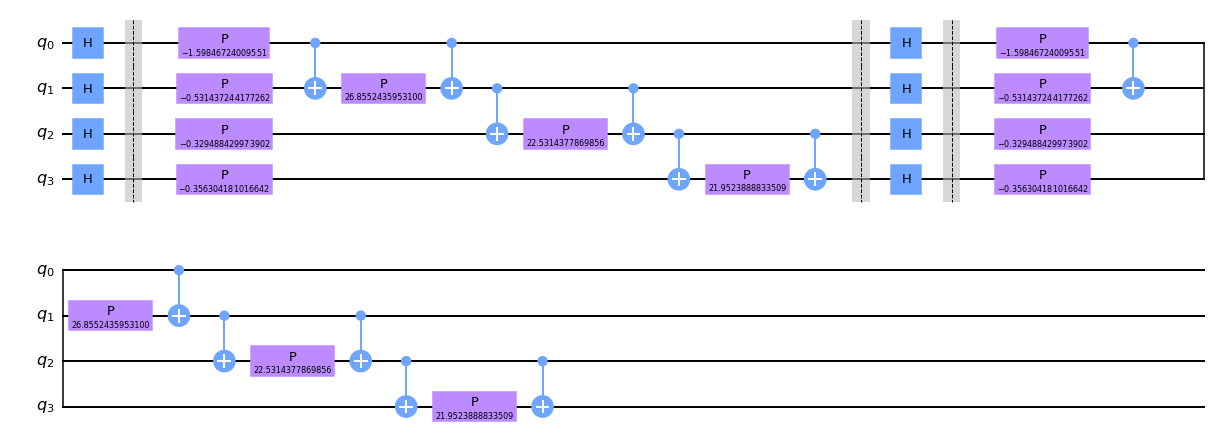

In [17]:
encode_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear', insert_barriers=True)
encode_circuit = encode_map.bind_parameters(sample_train[0])
encode_circuit.decompose().draw(output='mpl')

<div class="alert alert-block alert-success">

### Exercise 1: Data Encoding

Encode the data point $x = (-0.1,0.2)$ using the `ZZFeatureMap` with 4 repetitions and default data mapping function. 


</div>

In [18]:
x = [-0.1,0.2]

# YOUR CODE HERE

## Quantum Kernel Estimation

A quantum feature map, $\phi(\mathbf{x})$, naturally gives rise to a quantum kernel, $k(\mathbf{x}_i,\mathbf{x}_j)= \phi(\mathbf{x}_j)^\dagger\phi(\mathbf{x}_i)$, which can be seen as a measure of similarity: $k(\mathbf{x}_i,\mathbf{x}_j)$ is large when $\mathbf{x}_i$ and $\mathbf{x}_j$ are close. 

When considering finite data, we can represent the quantum kernel as a matrix: 
$K_{ij} = \left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2}$. We can calculate each element of this kernel matrix on a quantum computer by calculating the transition amplitude:
$$
\left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2} = 
\left| \langle 0^{\otimes n} | \mathbf{U_\phi^\dagger}(\mathbf{x}_j) \mathbf{U_\phi}(\mathbf{x_i}) | 0^{\otimes n} \rangle \right|^{2}
$$
assuming the feature map is a parameterized quantum circuit, which can be described as a unitary transformation $\mathbf{U_\phi}(\mathbf{x})$ on $n$ qubits. 

This provides us with an estimate of the quantum kernel matrix, which we can then use in a kernel machine learning algorithm, such as support vector classification.

As discussed in [*Havlicek et al*.  Nature 567, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2), quantum kernel machine algorithms only have the potential of quantum advantage over classical approaches if the corresponding quantum kernel is hard to estimate classically. 

As we will see later, the hardness of estimating the kernel with classical resources is of course only a necessary and not always sufficient condition to obtain a quantum advantage. 

However, it was proven recently in [*Liu et al.* arXiv:2010.02174 (2020)](https://arxiv.org/abs/2010.02174) that learning problems exist for which learners with access to quantum kernel methods have a quantum advantage over allclassical learners.

With our training and testing datasets ready, we set up the `QuantumKernel` class with the [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html), and use the `BasicAer` `statevector_simulator` to estimate the training and testing kernel matrices.

In [19]:
zz_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))

Let's calculate the transition amplitude between the first and second training data samples, one of the entries in the training kernel matrix.

In [20]:
print(sample_train[0])
print(sample_train[1])

[-0.79923362 -0.26571862 -0.16474421 -0.17815209]
[-0.81630337 -0.2918343  -0.48757339 -0.44903275]


First we create and draw the circuit:

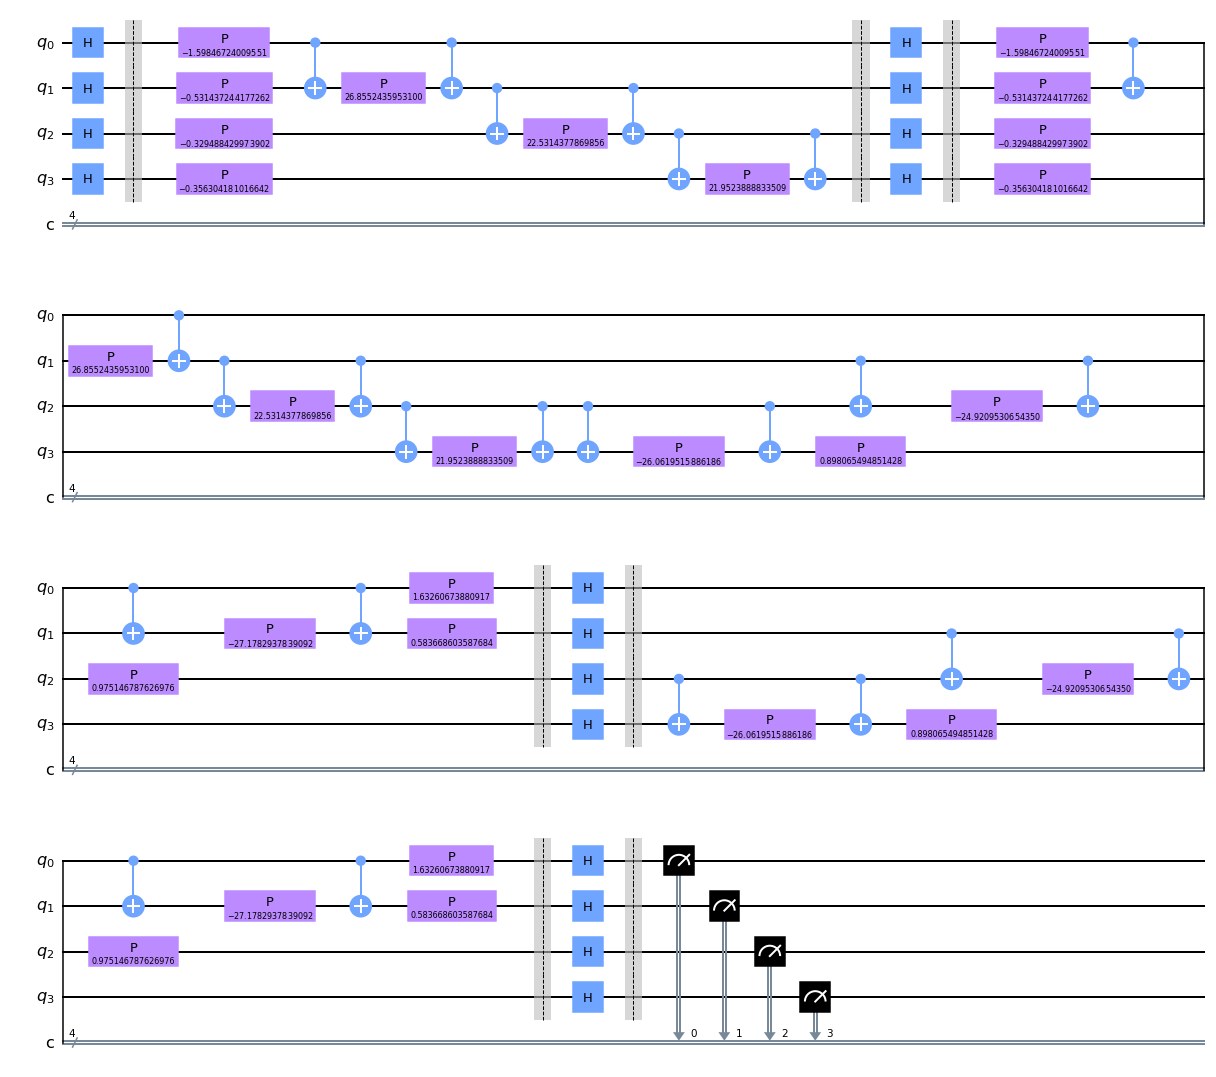

In [21]:
zz_circuit = zz_kernel.construct_circuit(sample_train[0], sample_train[1])
zz_circuit.decompose().decompose().draw(output='mpl')

The parameters in the gates are a little difficult to read, but notice how the circuit is symmetrical, with one half encoding one of the data samples, the other half encoding the other. 

We then simulate the circuit. We will use the `qasm_simulator` since the circuit contains measurements, but increase the number of shots to reduce the effect of sampling noise. 

In [22]:
backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(zz_circuit)

The transition amplitude is the proportion of counts in the zero state:

In [23]:
counts['0000']/sum(counts.values())

0.001953125

This process is then repeated for each pair of training data samples to fill in the training kernel matrix, and between each training and testing data sample to fill in the testing kernel matrix. Note that each matrix is symmetric, so to reduce computation time, only half the entries are calculated explictly. 

Here we compute and plot the training and testing kernel matrices:

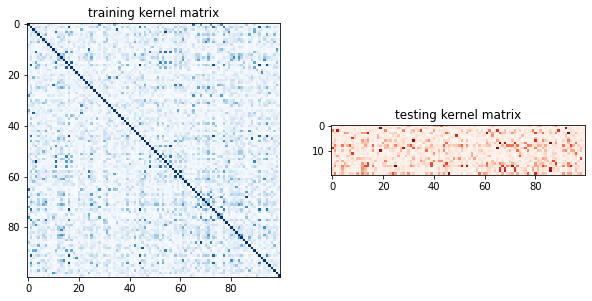

In [24]:
matrix_train = zz_kernel.evaluate(x_vec=sample_train)
matrix_test = zz_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

<div class="alert alert-block alert-success">

### Exercise 2: Quantum Kernel

Calculate the transition amplitute between $x=(−0.1,0.2)$ and $y=(0.4,-0.6)$ using the `ZZFeatureMap` with 4 repetitions and default data mapping function. Use the `qasm_simulator` with `shots = 8192`, `seed_simulator = 1024` and `seed_transpiler = 1024`.


</div>

In [25]:
x = [-0.1,0.2]
y = [0.4,-0.6]

# YOUR CODE HERE

## Quantum Support Vector Classification


Introduced in [*Havlicek et al*.  Nature 567, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2), the quantum kernel support vector classification algorithm consists of these steps:

<div>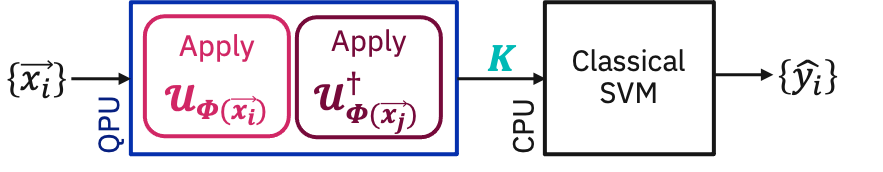</div> 

1. Build the train and test quantum kernel matrices.
    1. For each pair of datapoints in the training dataset $\mathbf{x}_{i},\mathbf{x}_j$, apply the feature map and measure the transition probability: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{x_j})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
    2. For each training datapoint $\mathbf{x_i}$ and testing point $\mathbf{y_i}$, apply the feature map and measure the transition probability: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{y_i})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
2. Use the train and test quantum kernel matrices in a classical support vector machine classification algorithm.

The `scikit-learn` `svc` algorithm allows us to define a [custom kernel](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) in two ways: by providing the kernel as a callable function or by precomputing the kernel matrix. We can do either of these using the `QuantumKernel` class in Qiskit.

The following code takes the training and testing kernel matrices we calculated earlier and  provides them to the `scikit-learn` `svc` algorithm:

In [26]:
zzpc_svc = SVC(kernel='precomputed')
zzpc_svc.fit(matrix_train, label_train)
zzpc_score = zzpc_svc.score(matrix_test, label_test)

print(f'Precomputed kernel classification test score: {zzpc_score}')

Precomputed kernel classification test score: 0.95


The following code gives the kernel as a callable function:

In [27]:
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(sample_train, label_train)
zzcb_score = zzcb_svc.score(sample_test, label_test)

print(f'Callable kernel classification test score: {zzcb_score}')

Callable kernel classification test score: 0.95


This is convenient, as we can easily compare the quantum kernel with various classical kernels:

In [28]:
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in classical_kernels:
    classical_svc = SVC(kernel=kernel)
    classical_svc.fit(sample_train, label_train)
    classical_score = classical_svc.score(sample_test, label_test)

    print('%s kernel classification test score:  %0.2f' % (kernel, classical_score))

linear kernel classification test score:  1.00
poly kernel classification test score:  0.95
rbf kernel classification test score:  1.00
sigmoid kernel classification test score:  1.00


### Exploration: Quantum Support Vector Classification

Try running Quantum Support Vector Classification with different Qiskit [feature maps](https://qiskit.org/documentation/apidoc/circuit_library.html#data-encoding-circuits) and [datasets](https://qiskit.org/documentation/machine-learning/apidocs/qiskit_machine_learning.datasets.html).